In [ ]:
from __future__ import annotations

import os
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.stats import chi2 as chi2_dist


def gauss(x: np.ndarray, A: float, mu: float, sigma: float) -> np.ndarray:
    """Funzione gaussiana per il fit dell’istogramma Δt."""
    return A * np.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))

def S_routine():
    
    E = np.zeros((2,2))
    E_err = np.zeros((2,2))

    for i in range(2):
        for j in range(2):
            print(f'Loading basis A{i},B{j}', end='')
            basis = BasisMeasurement(i,j)
            E[i,j] = basis.E
            E_err[i,j] = basis.E_err
            print(f' -> E = {E[i,j]:.3f} ± {E_err[i,j]:.3f}')
    
    S = np.sum(np.abs(E))
    S_err = np.sqrt(np.sum(E_err**2))

    print(f'S: {round(S,3)} ± {round(S_err,3)}')

class BasisMeasurement:

    ''' 
    Class to study CHSH inequality: 

        takes in input a txt file of a choosen basis and load (++),(+-),(-+),(--) measurement 
            measurement: [time tag [81 ps]: int, channel: int]

        in output some statistics relevant to the experiment
            - Signals delay distribution between channels
            - E(A_i, B_j) paramether 
    '''
    

    LABELS: Tuple[str, str, str, str] = ("++", "+-", "-+", "--")

    def __init__(
        self,
        x: int,                             # Choosen basis A_i 
        y: int,                             # Choosen basis B_j
        delta_window: int = 40,             # time interval for the study of signal delay [time tag unit]
        data_dir: str = "data/data_Old",    
        bin_width: int = 2,                 # time binning for gaussian approximation[time tag unit] 
        run_time: int = 5 * 1e12 / 81  #1 * 80.955 * 1e12       # 6s in 81 ps timetag
        
    ) -> None:
        
        self.x                              = x                           
        self.y                              = y
        self.data_dir                       = data_dir
        self.bin_width                      = bin_width
        self.delta_window                   = delta_window
        self.run_time                       = run_time
        

        self.raw_data: List[np.ndarray]     = self._load_basis_files()                  # raw data form txt file
        self.channels_A, self.channels_B    = self._extract_channels()                  # channel measures [time, idx]            
        self.delta_time                     = self._delta_arrival_between_channels()    # delta time between measures in the two channels 
        self.signals                        = self._find_signals()                      # time tag for signal measure
        self.signals_delay                  = self._signals_delay()                     # delta time between SIGNALS in the two channels 
        self.E, self.E_err                  = self._compute_E_xy()                      # E(A_i,B_j) value    

    def _basis_filenames(self) -> List[str]:
        '''
        gives all files for the choosen basis -> ++, +-, -+, --
        '''
        return [
            f"x{self.x}a{a}y{self.y}b{b}.txt"
            for a in (0, 1)
            for b in (0, 1)
        ]

    def _load_file(self, filename: str) -> np.ndarray:
        '''
        Load single txt file given the path
        '''
        path = os.path.join(self.data_dir, filename)
        file = np.loadtxt(path, delimiter=";")
        
        file[:,0] -= np.min(file[:,0])
        mask = file[:,0] <= self.run_time
        data = file[mask]

        return data
    
    def _load_basis_files(self) -> List[np.ndarray]:
        '''
        Load all the files for given basis
        '''
        return [self._load_file(f) for f in self._basis_filenames()]

    def _extract_channels(
        self,
    ) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        
        '''
        Gives the measurement for each channel with original raw file index
        '''

        channels_A: List[np.ndarray] = []
        channels_B: List[np.ndarray] = []

        for data in self.raw_data:
            # extract the channel flag
            chan_flags = np.unique(data[:, 1])

            flagA, flagB = chan_flags
            # original index
            idxA = np.where(data[:, 1] == flagA)[0]
            idxB = np.where(data[:, 1] == flagB)[0]

            # (timestamp, idx)
            chA = np.stack((data[idxA, 0], idxA), axis=1)
            chB = np.stack((data[idxB, 0], idxB), axis=1)

            channels_A.append(chA)
            channels_B.append(chB)

        return channels_A, channels_B

    def _delta_arrival_between_channels(
        self, 
    ) -> Tuple[List[np.ndarray]]:
        """
        Compute the delta time of measurement between the two channels
        """
        delta_time: List[np.ndarray] = []

        for i in range(len(self.raw_data)):

            # Extracting data 
            data = self.raw_data[i]
            chA = self.channels_A[i]
            chB = self.channels_B[i]

            # Selecting the inefficient channel 
            minor = chA if chA.shape[0] < chB.shape[0] else chB
            idx = minor[:-1, 1].astype(int)

            # Compute the time difference (delta) between each event in the inefficient channel
            # and the nearest preceding and following events in the efficient channel
            delta_plus = data[idx, 0] - data[idx + 1, 0]
            delta_minus = data[idx, 0] - data[idx - 1, 0]

            # Selecting the delta with lower latency
            dt = np.where(
                np.abs(delta_minus) < np.abs(delta_plus), delta_minus, delta_plus
            )
            delta_time.append(dt)

        return delta_time   
        
    def _find_signals(
        self,
    ) -> Tuple[List[np.ndarray]]:
        
        '''
        Collecting the timetag of real Signals 
        '''

        signals: List[np.ndarray] = []

        for i in range(len(self.raw_data)):
            
            # extracting data
            chA = self.channels_A[i]
            chB = self.channels_B[i]
            dt = self.delta_time[i]
            minor = chA if chA.shape[0] < chB.shape[0] else chB

            # selecting only events with delta time in the selected time window [50 time tag ~ 4ns] 
            # (avoiding noisy events distant from the physical ones)
            w    = self.delta_window
            mask = (dt >= -w) & (dt <=  w)
    
            signals.append(minor[:-1,0][mask])

        return signals
    
    def _signals_delay(
        self, 
    ) -> Tuple[np.ndarray]:
        
        '''
        Compute the delta time between channel for real signals
        '''
        sd: List[np.ndarray] = []

        for dt in self.delta_time:

            w    = self.delta_window
            mask = (dt >= -w) & (dt <=  w)
            sd.append(dt[mask])

        return sd   
    
    def _compute_hist_and_fit(
            self,
    ) -> Tuple:
        hist: List[np.ndarray] = []
        centers: List[np.ndarray] = []
        coeff: List[np.ndarray] = []

        # extracting binning paramethers 
        window = self.delta_window
        bin_width = self.bin_width

        # collecting signals
        for signals_del in self.signals_delay:

            # distribution of the delta time for signals
            bins = np.arange(-window, window + bin_width, bin_width)
            hh, ee = np.histogram(signals_del, bins)
            cc = (ee[:-1] + ee[1:]) / 2

            # gaussian fit 
            mu0 = np.average(cc, weights=hh)
            sig0 = np.sqrt(np.average((cc - mu0) ** 2, weights=hh))
            p0 = [hh.max(), mu0, sig0]
            bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])
            fit, _ = curve_fit(gauss, cc, hh, p0=p0, bounds=bounds)

            hist.append(hh)
            centers.append(cc)
            coeff.append(fit)


        return list(zip(hist, centers, coeff))

    def _compute_E_xy(
        self, empirical: bool = True,
        ) -> Tuple[float, float]:

        '''
        Compute the expecvtation value for the product E(A,B) needed to obrain S paramether
        '''

        counts_conf: list[int] = []
        errors_conf: list[float] = []

        # extracting delta time signals distribution 
        results = self._compute_hist_and_fit()     
        dt = self.delta_time   
        sig = self.signals_delay                

        for (hist, ctr, coeff), delta_time, signals in zip(results, dt, sig):

            if (empirical == True): # empitical frequencies 
                # counting only statistically significant signals 95% quantile 
                conf_int = np.quantile(signals,(0.025,0.975))
                mask = (delta_time >= conf_int[0]) & (delta_time <= conf_int[1])
                c = mask.sum() 

            else:  # Gaussian fit
                # counting only statistically significant signals (3*sig)
                mean, std = coeff[1], coeff[2]
                mask = (delta_time >= mean - 3 * std) & (delta_time <= mean + 3 * std)

            # n.of signals in the confidence interval 
            counts_conf.append(c)
            # poissonian error for the counts 
            errors_conf.append(np.sqrt(c))

        counts_conf = np.asarray(counts_conf, dtype=float)
        errors_conf = np.asarray(errors_conf, dtype=float)

        # final statistic 
        N = counts_conf.sum()
        E = (counts_conf[0] - counts_conf[1] - counts_conf[2] + counts_conf[3]) / N

        # error propagation
        error = np.sqrt(
            # numerator 
            np.sum((errors_conf / N) ** 2) + 
            # denominator              
            (E * np.sqrt(N) / N**2) ** 2                   
        )

        return E, error

    def _plot_signals_delay(
            self, show_fit: bool = True
            ) -> None:
        
        '''
        Plotting function for the delta time distribution of signals in the for different configurations ++, +-, -+, --
        '''

        fig, axes = plt.subplots(
            2, 2, figsize=(12, 8), sharex=True, sharey=True
        )
        ymax = 0

        results = self._compute_hist_and_fit()

        for (hist, ctr, coeff), ax, label in zip(results, axes.flatten(), self.LABELS):
            A, mu, sig = coeff  

           # Perfiorming statistical tests--------------------------------------------------------
            y_fit = gauss(ctr, A, mu, sig)                      # theorical prediction
            
            sigma = np.sqrt(hist) + 1e-10                       # empirical error
            chi2 = np.sum((hist - y_fit)**2 / (sigma**2))       # chi value with errors (Pearson)
            ndof = np.count_nonzero(hist) - 3                   # dof: meas - 3 fit paramethers
            chi2_red = chi2 / ndof                              # redused chi 
            p_value = 1 - chi2_dist.cdf(chi2, ndof)             # pval of the test
           #---------------------------------------------------------------------------------------      
            
            ymax = max(ymax, hist.max())
            ax.bar(
                ctr,
                hist,
                width=self.bin_width,
                color="yellowgreen",
                edgecolor="green",
                alpha=0.8,
                label=r"$\Delta t$",
            )

            ax.errorbar(
                ctr,
                hist,
                np.sqrt(hist),
                color = 'black',
                fmt=".",
                ms = 0.1,
                alpha=0.8,
                label='errors',

            )

            if show_fit:
                ax.plot(
                    ctr,
                    y_fit,
                    lw=1,
                    linestyle = '--',
                    marker = '.',
                    color="red",
                    label=fr"Gaussian fit: $\mu$={mu:.1f}, σ={sig:.1f}",
                )
                ax.axvspan(
                    mu - 3 * sig,
                    mu + 3 * sig,
                    color="gray",
                    alpha=0.15,
                    label="3σ",
                )

            ax.text(0.05, 0.95,
                fr"$\chi_\nu^2$ = {chi2_red:.2f}" + "\n" + fr'p = {p_value:.2}',
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
            
            ax.set_title(label)
            ax.grid(alpha=0.2)
            ax.legend()

        for ax in axes[:, 0]:
            ax.set_ylabel("Counts")
        for ax in axes[-1, :]:
            ax.set_xlabel(r"$\Delta$t,  bin width: 1 UTT")
        for ax in axes.flatten():
            ax.set_xlim(-self.delta_window, self.delta_window)
            ax.set_ylim(0, 1.1 * ymax)

        fig.text(0.99, 0.01, r"Unit: 1 UTT = 81 ps", ha='right', fontsize=10)
        fig.suptitle(fr"Signals delay between channels distribution (Gaussian) – Basis A{self.x} B{self.y}", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show() 

    def _plot_signals_interarrival(self):
        """
        takes physical signbals and compute the distribution of time inter-arrivals:
        theorical negative exponetial process -> fit with statistics
        """
    
        fig, axes = plt.subplots(
            2, 2, figsize=(12, 8), sharex=True, sharey=True
        )

        # setup for the exponential distribution
        nbins = 30                                     # bins in plot
        t_max = 0.4e8                                  # x max
        bin_width = t_max/nbins                     
        bins = np.linspace(0, t_max, nbins + 1)  
    
        for ax, sig, label in zip(axes.flatten(), self.signals, self.LABELS):
            
            
            # delta arrival
            delta_time = np.diff(sig)
            # lambda exp paramether
            lam = 1.0 / delta_time.mean()

            hist, bin_edges = np.histogram(delta_time, bins=bins)
            ctr = (bin_edges[:-1] + bin_edges[1:]) / 2

            ax.bar(
                ctr,
                hist,
                width=bin_width,
                color="lightblue",
                edgecolor="blue",
                alpha=0.8,
                label=r"$\Delta t$",
            )

            # Statistical test --------------------------------------------------
            t_axis = np.linspace(0, t_max, nbins)
            fit = len(delta_time) * bin_width * lam * np.exp(-lam * ctr)     # theorical prediction 
            ndof = np.count_nonzero(hist) - 1                                   # dof: meas - 1 (lambda par)
            sigma = np.sqrt(hist)                                               # empirical error 
            chi2_val = np.sum((hist - fit)**2 / (sigma**2))                     # Pearson (chi with empirical errors)
            chi2_red = chi2_val / ndof                                          # reduced chi square
            p_value = 1 - chi2_dist.cdf(chi2_val, ndof)                         # pval
            #--------------------------------------------------------------------

            ax.errorbar(
                ctr,
                hist,
                np.sqrt(hist),
                color = 'black',
                fmt=".",
                ms = 0.1,
                alpha=0.8,
                label='errors',                
            )
            
            ax.plot(
                ctr,
                fit,
                linestyle='--',
                marker = '.',
                ms = 4,
                color='red',
                lw=1,
                label=f"exp fit: λ = {lam:.2e}"
            )

            ax.set_title(label)
            ax.text(0.05, 0.95,
                    fr"$\chi^2_\nu$ = {chi2_red:.2f}" + "\n" + fr"$p$ = {p_value:.2f}",
                    transform=ax.transAxes,
                    va='top',
                    fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

        for ax in axes[:, 0]:
            ax.set_ylabel("Counts")
        for ax in axes[-1, :]:
            ax.set_xlabel(fr"$\Delta$t")
        for ax in axes.flatten():
            ax.set_xlim(0, t_max)
            ax.grid(alpha=0.2)
            ax.legend()

        fig.text(0.99, 0.01, r"Unit: 1 UTT = 81 ps", ha='right', fontsize=10)
        fig.suptitle(fr"Signals inter-arrival delta time distribution – Basis A{self.x} B{self.y}", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def _plot_signals_poisson(self):
        """
        tekes the physical signals,  and return the distribution for the counts in specific time windows
        theorical poisson process -> fit with poisson distribution 
        """

        fig, axes = plt.subplots(
            2, 2, figsize=(12, 8), sharex=False, sharey=True
        )

        for ax, sig, label in zip(axes.flatten(), self.signals, self.LABELS):

            # time measurement window
            bin_width = 1e8                 # ~ 100 times negative exponential binning
            T = bin_width

            # counting signals for time window
            edges = np.arange(sig[0], sig[-1] + T, T)
            counts, _ = np.histogram(sig, bins=edges)
            N = counts.size

            # empirical frequencies
            k_emp, freq_counts = np.unique(counts, return_counts=True)
            freq_emp = freq_counts / N
            sigma = np.sqrt(freq_emp * (1 - freq_emp) / N)                  # Bernoulli trials empirical error

            # poisson mean
            mu = counts.mean()
            mu_sci = f"{mu:.2e}" if mu < 1e-2 or mu > 1e2 else f"{mu:.2f}"

            # theorical prediction
            p_theo = poisson.pmf(k_emp, mu)

            # chi square test as before 
            valid = sigma > 0
            chi_sq = np.sum(((freq_emp[valid] - p_theo[valid]) ** 2) / sigma[valid]**2) 
            dof = np.count_nonzero(valid) - 1  # n_bin - 1
            chi_sq_red = chi_sq/dof
            p_val = 1 - chi2_dist.cdf(chi_sq, dof)

            
            ax.bar(
                k_emp,
                freq_emp,
                width = 1,
                color='lightpink',
                edgecolor = 'magenta',
                label="PDF",
                alpha= 0.6     

            )
            # Plot empirical freq
            ax.errorbar(
                k_emp,
                freq_emp,
                yerr=sigma,
                color='black',
                fmt=".",
                ms = 0.1,
                label="error",
                lw = 0.8

            )

            # Fit 
            ax.plot(
                k_emp,
                poisson.pmf(k_emp, mu),
                color='red',
                linestyle="--",
                marker='.',
                lw=1,
                label=fr"Poisson fit: $\mu = {mu_sci}$"
            )

            ax.text(0.05, 0.95,
            fr"$\chi^2_\nu$ = {chi_sq_red:.2f}" + "\n" + fr"$p$ = {p_val:.2f}",
            transform=ax.transAxes,
            va='top',
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

            ax.set_xlabel("Counts")
            ax.set_ylabel("Probability")
            ax.set_title(label)
            ax.set_xticks(k_emp)
            ax.grid(alpha=0.2)
            ax.legend()

        fig.text(0.99, 0.01, r"Unit: 1 UTT = 81 ps", ha='right', fontsize=10)
        fig.suptitle(fr"Signals count distribution in 1e8 UTT - A{self.x} B{self.y}", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [3]:
S_routine()

Loading basis A0,B0 -> E = 0.633 ± 0.007
Loading basis A0,B1 -> E = 0.784 ± 0.007
Loading basis A1,B0 -> E = 0.602 ± 0.007
Loading basis A1,B1 -> E = -0.501 ± 0.007
S: 2.519 ± 0.014


In [4]:
Basis00 = BasisMeasurement(0,0)
Basis01 = BasisMeasurement(0,1)
Basis10 = BasisMeasurement(1,0)
Basis11 = BasisMeasurement(1,1)

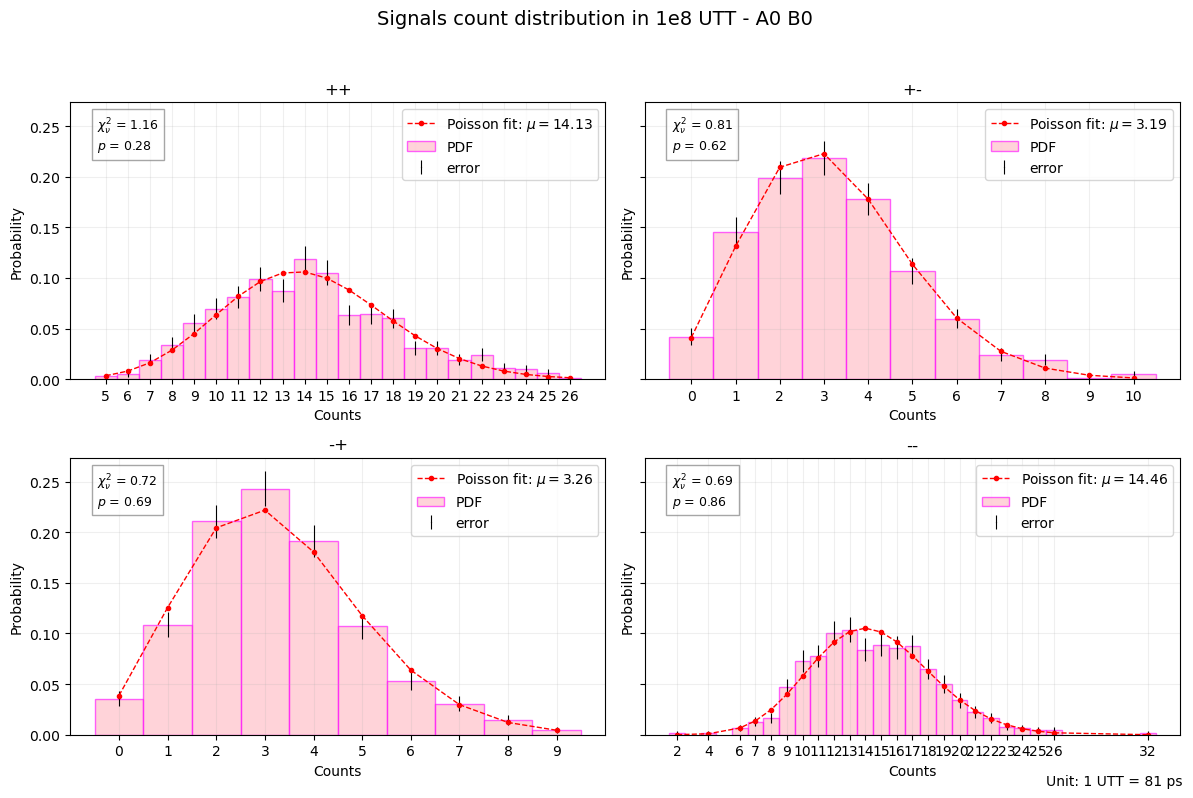

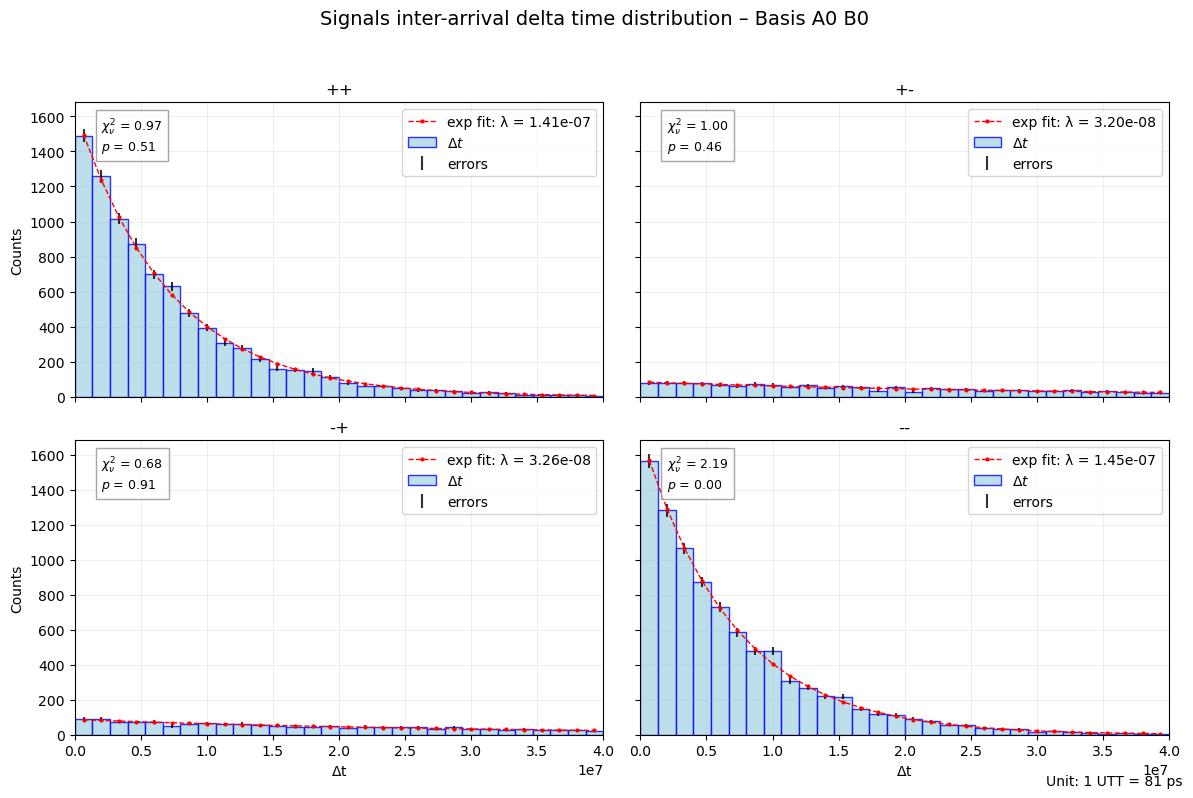

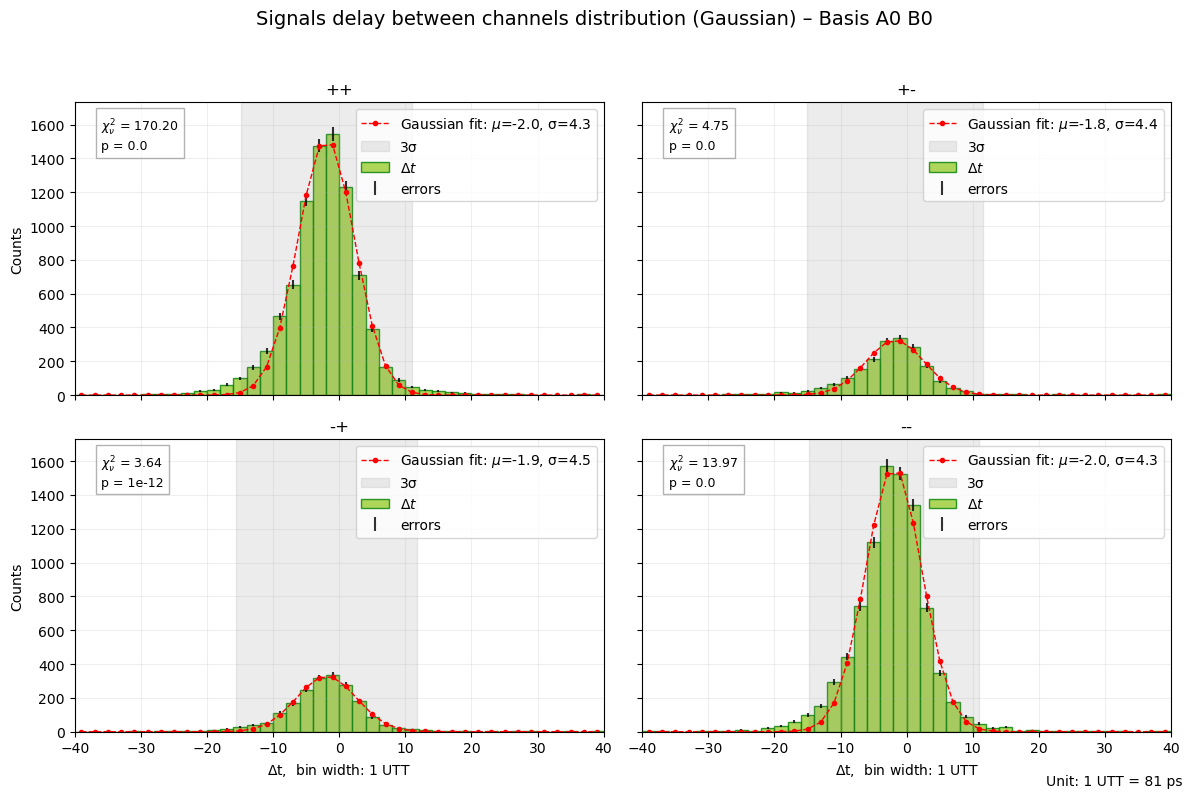

In [5]:
Basis00._plot_signals_poisson()
Basis00._plot_signals_interarrival()
Basis00._plot_signals_delay()

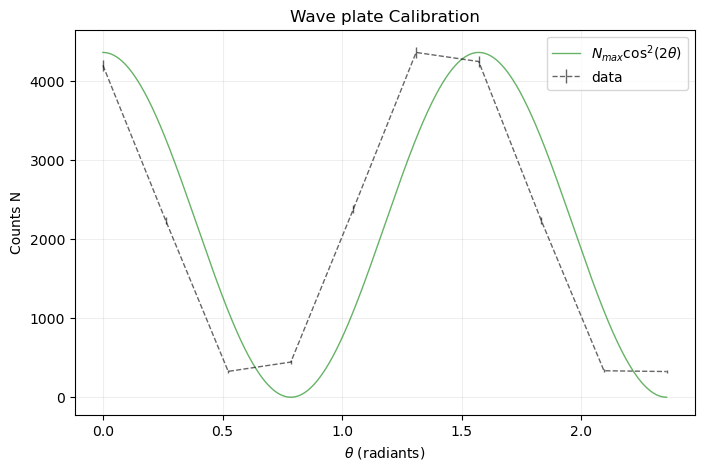

In [ ]:
waveplate = np.loadtxt('data/Waveplate_A.csv', delimiter=',')

x = (waveplate[:, 0])*np.pi /180 # in radians 
y = waveplate[:, 1]

x_fit = np.arange(0,np.max(x),0.001)
y_fit = np.max(y)*(np.cos(2*x_fit)**2)

fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.errorbar(x, y, np.sqrt(y), fmt='--', label='data', lw=1, color = 'black', alpha=0.6)
ax.plot(x_fit, y_fit, '-', lw=1, color = 'green', alpha = 0.6,
         label=r'$N_{max} \cos^2(2\theta)$')

ax.set_xlabel(r'$\theta$ (radiants)')
ax.set_ylabel('Counts N')
ax.set_title('Wave plate Calibration')
ax.grid(alpha = 0.2)
ax.legend()
plt.show()